In [25]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import callbacks
from tensorflow.keras.layers import Dropout


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

In [26]:
# load the dataset as time series data
df = pd.read_csv('fifthClean.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
df.head()

C:\Users\admin\AppData\Local\Temp\ipykernel_26464\705661990.py:2: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  df = pd.read_csv('fifthClean.csv', header=0, index_col=0, parse_dates=True, squeeze=True)


,Latitude,Longitude,Year,Month,Day,Hour,Minute,Second
0,51.513952,-0.085833,2019,12,1,2,17,49
1,51.511625,-0.081549,2019,12,2,3,14,4
2,51.509775,-0.085014,2019,12,2,4,51,16
3,51.517431,-0.082458,2019,12,3,9,48,8
4,51.516814,-0.081620,2019,12,4,2,53,26


In [27]:
# scale the data to be between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
df = pd.DataFrame(scaler.fit_transform(df))

In [28]:
# create time_steps to be used in the LSTM model
time_steps = 10
# create a function to create the time steps
def create_time_steps(df,time_steps):
    time_steps = time_steps
    X = []
    y = []
    # read take 7  rows of data and predict the 8th row
    for i in range(len(df)-time_steps):
        X.append(df.iloc[i:(i+time_steps)].values)
        y.append(df.iloc[i+time_steps].values)
    return np.array(X), np.array(y)

# create the time steps
X, y = create_time_steps(df,time_steps)
print(X.shape)
print(y.shape)


(2084, 10, 8)
(2084, 8)


In [29]:
print(X)


[[[0.29441565 0.18853324 0.         ... 0.08695652 0.28813559 0.83050847]
  [0.27347659 0.20698134 0.         ... 0.13043478 0.23728814 0.06779661]
  [0.25682972 0.19206008 0.         ... 0.17391304 0.86440678 0.27118644]
  ...
  [0.32796134 0.22018009 0.         ... 0.52173913 0.62711864 0.30508475]
  [0.33319836 0.17832735 0.         ... 0.2173913  0.52542373 0.49152542]
  [0.33319836 0.17832735 0.         ... 0.2173913  0.74576271 0.49152542]]

 [[0.27347659 0.20698134 0.         ... 0.13043478 0.23728814 0.06779661]
  [0.25682972 0.19206008 0.         ... 0.17391304 0.86440678 0.27118644]
  [0.32572076 0.20306693 0.         ... 0.39130435 0.81355932 0.13559322]
  ...
  [0.33319836 0.17832735 0.         ... 0.2173913  0.52542373 0.49152542]
  [0.33319836 0.17832735 0.         ... 0.2173913  0.74576271 0.49152542]
  [0.32016881 0.2066756  0.         ... 0.26086957 0.22033898 0.13559322]]

 [[0.25682972 0.19206008 0.         ... 0.17391304 0.86440678 0.27118644]
  [0.32572076 0.203066

In [30]:
# reshape y to dim 3
y = y.reshape((y.shape[0], y.shape[1], 1))
print(X.shape, y.shape)

(2084, 10, 8) (2084, 8, 1)


In [31]:
# split into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1667, 10, 8) (1667, 8, 1) (417, 10, 8) (417, 8, 1)


In [32]:
def plot_mae(history,range,title): #plot the mae
    plt.figure(figsize=(16,8))
    plt.title(title)
    plt.ylabel('Validation mae')
    plt.xlabel('Epochs')
    plt.plot(history['mae'][:range], label='Training mae', color='red')
    plt.plot(history['val_mae'][:range], label='Validation mae', color='green')
    # set x interval to 1
    plt.xticks(np.arange(0, range, 1.0))

    plt.legend(
        loc='upper right',
        shadow=True,
        fontsize='x-large'
    )
    plt.show()

Epoch 1/100
4/4 [==============================] - 4s 316ms/step - loss: 0.1798 - mae: 0.3387 - val_loss: 0.0614 - val_mae: 0.1916
Epoch 2/100
4/4 [==============================] - 0s 20ms/step - loss: 0.0598 - mae: 0.1877 - val_loss: 0.0542 - val_mae: 0.1792
Epoch 3/100
4/4 [==============================] - 0s 23ms/step - loss: 0.0534 - mae: 0.1773 - val_loss: 0.0532 - val_mae: 0.1759
Epoch 4/100
4/4 [==============================] - 0s 24ms/step - loss: 0.0520 - mae: 0.1737 - val_loss: 0.0491 - val_mae: 0.1681
Epoch 5/100
4/4 [==============================] - 0s 22ms/step - loss: 0.0485 - mae: 0.1654 - val_loss: 0.0466 - val_mae: 0.1590
Epoch 6/100
4/4 [==============================] - 0s 22ms/step - loss: 0.0471 - mae: 0.1610 - val_loss: 0.0489 - val_mae: 0.1705
Epoch 7/100
4/4 [==============================] - 0s 21ms/step - loss: 0.0462 - mae: 0.1607 - val_loss: 0.0416 - val_mae: 0.1476
Epoch 8/100
4/4 [==============================] - 0s 21ms/step - loss: 0.0414 - mae: 0.1

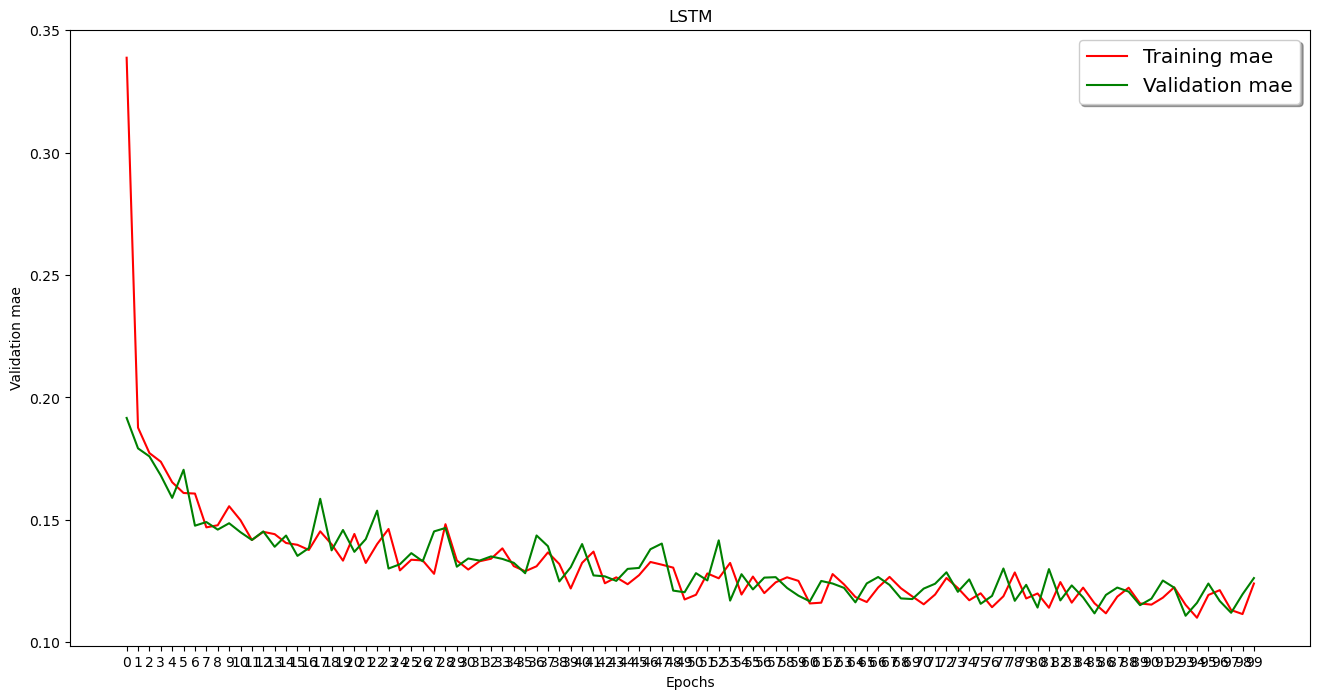

In [47]:
model = models.Sequential()
model.add(layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(layers.LSTM(32, return_sequences=True))
# model.add(layers.LSTM(512, return_sequences=True))
# model.add(layers.LSTM(256, return_sequences=True))
# model.add(layers.LSTM(128, return_sequences=True))
model.add(layers.LSTM(64))
model.add(layers.Dense(8))
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

# fit model
history = model.fit(X_train, y_train, epochs=100, verbose=1, validation_data=(X_test, y_test),batch_size=512)

# plot the mae
plot_mae(history.history,100,'LSTM')



In [48]:
# predict the test set
y_pred = model.predict(X_test)
print(y_pred.shape)

14/14 [==============================] - 2s 11ms/step
(417, 8)


In [49]:
# print the first 10 predictions
print(y_pred[:10])
# reshape y_test to dim 2
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1]))
print(y_test.shape)


[[0.2705603  0.14829715 0.9131114  0.5846673  0.5203364  0.54917496
  0.48828226 0.43841016]
 [0.29668677 0.19058675 0.23736754 0.8812459  0.7815852  0.26474595
  0.4647652  0.42140308]
 [0.27387843 0.17583306 0.5662305  0.67418605 0.61065865 0.19381553
  0.48256332 0.3984741 ]
 [0.27051505 0.17885956 0.5908356  0.16970366 0.6223292  0.21811375
  0.516701   0.41137296]
 [0.28356746 0.15072    0.9190152  0.3209478  0.62229353 0.5746257
  0.5078088  0.42526463]
 [0.27420783 0.15015703 0.8957354  0.7231225  0.433604   0.47243983
  0.476178   0.46731743]
 [0.27422023 0.18199839 0.88803035 0.01206221 0.65553945 0.24978553
  0.5514847  0.401489  ]
 [0.30039486 0.172075   0.62102896 0.12487419 0.5306118  0.31079897
  0.49241936 0.45827934]
 [0.2802137  0.16190578 0.5894485  0.6906247  0.46890813 0.25130183
  0.4656164  0.4603616 ]
 [0.29896146 0.16162099 0.27621534 0.5232196  0.2340271  0.20100306
  0.42455035 0.49009   ]]
(417, 8)
